# Assignment 3 - Chemistry Solver
Due: 2018-05-04

Your next assignment is to develop an ODE solver that follows the evolution of the nine species of H, H+, H-, He, He+, He++, H2, H2+ and e-.

You can use the Grackle method paper for this assignment.

* Look up the chemical kinetic rate equations
* Develop a right-hand side calculation. You may do this by hand, or using SymPy as we did in class.
* Calculate the rate coefficients as a function of temperature; you can assume an ideal gas law for the temperature.
* Utilize the SciPy integrators to evolve a network of reactions drawn from the Grackle methods paper.

You will have until May 4. (May the Fourth be with you.)

You should produce the following items:

Python code that runs from the command line that accepts
* Initial H ionization fraction
* Initial He ionization fraction
* Molecular hydrogen fraction
* Density
* Time to evolve to
* Integrator to use inside scipy.integrate.ode

It also should include:
* An integrator that updates based on some safety factor until the time is reached
* A set of visualizations that show overall change in the various fractions.
* A writeup


## Write-Up
Your code must be documented; this does not mean extensive comments, but it does mean that each routine must have a brief outline of what it is doing. You must also provide a notebook or other report that walks through how to utilize the code and what to expect.

You must evaluate the following items:

* When is it slower and faster? When it is near equilibrium or far?
* Do you see any particularly interesting regions in phase space?
* What was easy or hard?

In [72]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import sympy
import scipy.integrate as sint

Below are all of the rate equation functions taken from the grackle source code. To get these equations I mainly looked at the calc_rate_g.F and coll_rates_g.F files in "grackle / src / clib / ". I had to convert these functions from Fortran to python code, but that wasn't too bad. All of the rate equation functions for the interactions including the photons could not be found but Dr. Turk assured me that was okay.

I had a coupon from the previous assignement so I was told that we only had to do the six species network. I was told this after I had already started implementing for the nine species network, so that is why many of the other k functions are included. I'll leave them in anyway.

In [73]:
def k1_function(T):
    T_eV = T / 11605.0
    log_T_eV = np.log(T_eV)
    rv = np.exp(-32.71396786375
          + 13.53655609057*log_T_eV
          - 5.739328757388*log_T_eV**2 
          + 1.563154982022*log_T_eV**3
          - 0.2877056004391*log_T_eV**4
          + 0.03482559773736999*log_T_eV**5
          - 0.00263197617559*log_T_eV**6
          + 0.0001119543953861*log_T_eV**7
          - 2.039149852002e-6*log_T_eV**8)
    return rv

def k2_function(T):
    rv = 4.881357e-6*T**(-1.5)* (1.+1.14813e2 * T**(-0.407))**(-2.242)
    return rv

def k3_function(T):
    T_eV = T / 11605.0
    log_T_eV = np.log(T_eV)
    rv = np.exp(-44.09864886561001
             + 23.91596563469*log_T_eV
             - 10.75323019821*log_T_eV**2
             + 3.058038757198*log_T_eV**3
             - 0.5685118909884001*log_T_eV**4
             + 0.06795391233790001*log_T_eV**5
             - 0.005009056101857001*log_T_eV**6
             + 0.0002067236157507*log_T_eV**7
             - 3.649161410833e-6*log_T_eV**8)
    return rv

def k4_function(T):
    T_eV = T / 11605.0
    rv = (1.54e-9*(1.0+0.3 / 
             np.exp(8.099328789667/T_eV))
             / (np.exp(40.49664394833662/T_eV)*T_eV**1.5)
             + 3.92e-13/T_eV**0.6353)
    return rv

def k5_function(T):
    T_eV = T / 11605.0
    log_T_eV = np.log(T_eV)
    rv = np.exp(-68.71040990212001
             + 43.93347632635*log_T_eV
             - 18.48066993568*log_T_eV**2
             + 4.701626486759002*log_T_eV**3
             - 0.7692466334492*log_T_eV**4
             + 0.08113042097303*log_T_eV**5
             - 0.005324020628287001*log_T_eV**6
             + 0.0001975705312221*log_T_eV**7
             - 3.165581065665e-6*log_T_eV**8)
    return rv

def k6_function(T):
    rv = 7.8155e-5*T**(-1.5) * (1.+2.0189e2* T**(-0.407))**(-2.242)
    return rv 

def k7_function(T):
    T_eV = T / 11605.0
    log_T_eV = np.log(T_eV)
    rv = np.exp(-20.37260896533324
             + 1.139449335841631*log_T_eV
             - 0.1421013521554148*log_T_eV**2
             + 0.00846445538663*log_T_eV**3
             - 0.0014327641212992*log_T_eV**4
             + 0.0002012250284791*log_T_eV**5
             + 0.0000866396324309*log_T_eV**6
             - 0.00002585009680264*log_T_eV**7
             + 2.4555011970392e-6*log_T_eV**8
             - 8.06838246118e-8*log_T_eV**9) 
    return rv

def k8_function(T):
    rv = 1.75e-17 *T**1.3 * np.exp(-1.578 / T)
    return rv

#9,10,11 Could not find in Source Code


def k12_function(T):
    rv = 3.0e-16 * (T/3e2)**0.95 * np.exp(-T/9.32e3)
    return rv

def k13_function(T):
    rv = 1.35e-9*(T**9.8493e-2 + 3.2852e-1 * T**5.5610e-1 + 2.771e-7 * T**2.1826) \
            / (1 + 6.191e-3 * T**1.0461 + 8.9712e-11 * T**3.0424 + 3.2576e-14 * T**3.7741)
    return rv

def k14_function(T): 
    rv = 2.10e-20 * (T/30.0)**(-0.15) 
    return rv

def k15_function(T = None):
    rv = 6.0e-10
    return rv

def k16_function(T):
    log_T = np.log10(T)
    rv = (np.exp(-21237.15/T) * (- 3.3232183e-07 + 3.3735382e-07 * log_T - 1.4491368e-07 * log_T**2 \
                             + 3.4172805e-08 * log_T**3 - 4.7813720e-09 * log_T**4 + 3.9731542e-10 * log_T**5\
                             - 1.8171411e-11 * log_T**6 + 3.5311932e-13 * log_T**7))
    return rv

def k17_function(T):
    rv = 4.4886e-9*T**0.109127*np.exp(-101858/T)
    return rv

def k18_function(T):
    T_eV = T/11605
    rv = 1.0670825e-10*T_eV**2.012/(np.exp(4.463/T_eV)*(1+0.2472* T_eV)**3.512)
    return rv


def k19_function(T):
    T_eV = T / 11605.0
    log_T_eV = np.log(T_eV)
    rv = np.exp(-18.01849334273
             + 2.360852208681*log_T_eV
             - 0.2827443061704*log_T_eV**2
             + 0.01623316639567*log_T_eV**3
             - 0.03365012031362999*log_T_eV**4
             + 0.01178329782711*log_T_eV**5
             - 0.001656194699504*log_T_eV**6
             + 0.0001068275202678*log_T_eV**7
             - 2.631285809207e-6*log_T_eV**8)
    return rv

def k20_function(T):
    T_eV = T / 11605.0
    log_T_eV = np.log(T_eV)
    rv = np.exp(-20.37260896533324
             + 1.139449335841631*log_T_eV
             - 0.1421013521554148*log_T_eV**2
             + 0.00846445538663*log_T_eV**3
             - 0.0014327641212992*log_T_eV**4
             + 0.0002012250284791*log_T_eV**5
             + 0.0000866396324309*log_T_eV**6
             - 0.00002585009680264*log_T_eV**7
             + 2.4555011970392e-6*log_T_eV**8
             - 8.06838246118e-8*log_T_eV**9)
    return rv
    
def k21_function(T):
    rv = 2.4e-6*(1.0+T/2e4)/np.sqrt(T)
    return rv
    
def k22_function(T):
    rv = 4.0e-4*T**(-1.4)*np.exp(-15100/T)
    return rv

def k23_function(T):
    rv = 1.32e-6 * T**(-0.76)
    return rv

def k24_function(T):
    rv = 5.e-7*np.sqrt(100.0/T)
    return rv
    
def k25_function(T):
    T_eV = T / 11605.0
    rv = 1.0670825e-10*T_eV**2.012 / (np.exp(4.463/T_eV)*(1.0+0.2472* T_eV)**3.512)
    return rv

#This may not be right?
def k26_function(T):
    rv = 2.8e-31 * (T**(-0.6e0))
    return rv

#27-32 Could not find in the source code

It should also be noted that some of these k's could not be found anywhere in the grackle source code. For those that were not found there I referenced the following paper: 
https://arxiv.org/pdf/1604.03372.pdf

However, this was only relevent when I was considering the nine species network

Here is a plot of all the rate equation functions I will be considering over time:

/home/derek/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp


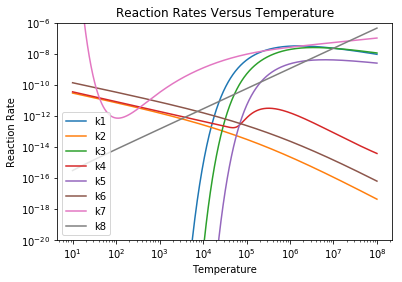

In [74]:
Ts = np.logspace(1, 8, 1024)

plt.loglog(Ts, k1_function(Ts), label = 'k1')
plt.loglog(Ts, k2_function(Ts), label = 'k2')
plt.loglog(Ts, k3_function(Ts), label = 'k3')
plt.loglog(Ts, k4_function(Ts), label = 'k4')
plt.loglog(Ts, k5_function(Ts), label = 'k5')
plt.loglog(Ts, k6_function(Ts), label = 'k6')
plt.loglog(Ts, k7_function(Ts), label = 'k7')
plt.loglog(Ts, k8_function(Ts), label = 'k8')
    
plt.title("Reaction Rates Versus Temperature")
plt.xlabel("Temperature")
plt.ylabel("Reaction Rate")
plt.ylim(1e-20, 1e-6)
plt.legend()
plt.show()

This plot is important because it can help us to identify when we expect to see the bulk of intersing transistions in our number density plots. Based on the this we can expect to see these occuring at a temperature of 10^4 K or 10^5 K

Here I define all of the variables I will use for generating the rhs of the equations.

I will be using sympy to do this

In [5]:
H, Hp, Hm, He, Hep, Hepp, H2, H2p, grain, de = sympy.sympify("H, Hp, Hm, He, Hep, Hepp, H2, H2p, grain, de")
k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20,k21,k22,k23,k24,k25,k26,k27,k28,k29,k30,k31,k32 = sympy.sympify("k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20,k21,k22,k23,k24,k25,k26,k27,k28,k29,k30,k31,k32")

Below are all of the reactions being considered. There are 32 of them because I was considering the nine species network. However, I will only select the first 8 of them for the six species network

In [6]:
r1 = (H + de), (Hp + de + de), k1
r2 = (Hp + de), (H), k2
r3 = (He + de), (Hep + de + de), k3
r4 = (Hep + de), (He), k4
r5 = (Hep + de), (Hepp + de + de), k5
r6 = (Hepp + de), (Hep), k6
r7 = (H + H), (Hp + de + H), k7
r8 = (H + He), (Hp + de + He), k8
r9 = (H), (Hp + de), k9
r10 = (He), (Hep + de), k10
r11 = (Hep), (Hepp + de), k11
r12 = (H + de), (Hm), k12
r13 = (Hm + H), (H2 + de), k13
r14 = (H + Hp), (H2p), k14
r15 = (H2p + H), (H2 + Hp), k15
r16 = (H2 + Hp), (H2p + H), k16
r17 = (H2 + de), (H + H + de), k17
r18 = (H2 + H), (H + H + H), k18
r19 = (Hm + de), (H + de + de), k19
r20 = (Hm + H), (H + de + H), k20
r21 = (Hm + Hp), (H + H), k21
r22 = (Hm + Hp), (H2p + de), k22
r23 = (H2p + de), (H + H), k23
r24 = (H2p + Hm), (H2 + H), k24
r25 = (H + H + H), (H2 + H), k25
r26 = (H + H + H2), (H2 + H2), k26
r27 = (Hm), (H + de), k27
r28 = (H2p), (H + Hp), k28
r29 = (H2), (H2p + de), k29
r30 = (H2p), (Hp + Hp + de), k30
r31 = (H2), (H + H), k31
r32 = (H + H + grain), (H2 + grain), k32

Here is where I select the 8 rections to be used for the six species network. The [r1,r2] was used only for testing to make sure my results matched what was derived in class.

In [7]:
all_reactions = [r1, r2, r3, r4, r5, r6, r7, r8]
#all_reactions = [r1, r2]

In [8]:
all_reactions

[(H + de, Hp + 2*de, k1),
 (Hp + de, H, k2),
 (He + de, Hep + 2*de, k3),
 (Hep + de, He, k4),
 (Hep + de, Hepp + 2*de, k5),
 (Hepp + de, Hep, k6),
 (2*H, H + Hp + de, k7),
 (H + He, He + Hp + de, k8)]

Below are the find_formation and the find_destruction functions. These functions were taken from what we did in lecture and I did not make any changes to these functions. 

In [9]:
def find_formation(species):
    rxns = []
    for r in all_reactions:
        if species in r[1].atoms():
            rxns.append(r)
    return rxns
    
def find_destruction(species):
    rxns = []
    for r in all_reactions:
        if species in r[0].atoms():
            rxns.append(r)
    return rxns

Below is the get_rhs function. Given a species variable it will produce the rhs for that function which corresponds to the time derivative of the number density of that species. The idea of this function came from what we coded up in lecture, but I made some changes to it because I think there were some mistakes in what was done.

First, I changed what the function examines from lhs.atoms and rhs.atoms to lhs.args and rhs.args. This was done because the atoms function would not include the coefficent in front of a speices in the reactions. This would cause the multiplication for those with a coefficent > 1 to only be considered once when they should be considered as many times as the coefficent. In order to remedy this I added if statements to multipily by 2 or 3 depending on the reaction being considered. This was only an issue in the rhs part.

I only considered 2 and 3 because those would be the coefficents that appear on the rhs for the six and nine species network. However, this is not a general fix for any number or type of species.

In [10]:
def get_rhs(species):
    dSdt = 0
    for lhs, rhs, coeff in find_formation(species):
        term = coeff
        for atom in list(lhs.args):
            term *= atom
        for atom in list(rhs.args):
            if ("2*" + str(species) in str(atom)):
                term *= 2
            if ("3*" + str(species) in str(atom)):
                term *= 3
        dSdt += term
    
    for lhs, rhs, coeff in find_destruction(species):
        term = -coeff
        for atom in list(lhs.args):
            term *= atom
        dSdt += term
    
    return dSdt

The below equation was used when I was trying to evaluate the rhs symbolically at every time step. I was trying to find a way to generate all of the equations beforehand and then just sub in variables for them during the time steps. The reason I was trying to do this will be explained below. In the end, the only thing it was helpful for was to generate all of the equations I need to code up.

In [11]:
def get_all_equations(elements):
    rv = []
    for species in elements:
        temp = get_rhs(species)
        rv.append(temp)
    return rv

In [12]:
get_all_equations([H, Hp, He, Hep, Hepp, de])

[-H*He*k8 - H*de*k1 + Hp*de*k2,
 H*He*k8 + H*de*k1 + 2*H*k7 - Hp*de*k2,
 -He*de*k3 + Hep*de*k4,
 He*de*k3 - Hep*de*k4 - Hep*de*k5 + Hepp*de*k6,
 Hep*de*k5 - Hepp*de*k6,
 H*He*k8 + H*de*k1 + 2*H*k7 + He*de*k3 - Hep*de*k4 + Hep*de*k5 - Hepp*de*k6 - Hp*de*k2]

So the rhs function. I tried initially to have it generate the equations symbolically and then just sub into them from there. I wanted to do this so that you would only have to input the elements you want to consider and then it would automatically generate the correct equations. I got this working, but the only issue was that it ran CRAZY SLOW! I am guessing the main limiting factor was subbing into the sympy equations. I did try speeding it up in a few different ways, but none seemed to help. Eventually, I gave in and just manually coded in the equations my get_all_equations function returned. I decided to consider a few different element cases instead and have that be an input parameter.

I left the old code in the Assignment_3_old file if you would like to take a look at what I was trying to do

I changed the rhs to not calculate the dnedt because of what Dr.Turk said in the Slack chat. I instead calculated this separately and used it as an input into the rhs function. This will be discussed more later.

In [56]:
def rhs(t, state,  element_case, de, T):
    #Element Case 1: elements = [H, Hp, de]
    #Element Case 2: elements = [H, Hp, He, Hep, Hepp, de]
    #Element Case 3: elements = [H, Hp, Hm, He, Hep, Hepp, H2, H2p, grain, de]
    
    if element_case == 1:
        H, Hp = state[0], state[1]
        dnHdt = Hp * de * k2_function(T) - H * de * k1_function(T)
        dnHpdt = H * de * k1_function(T) - Hp * de * k2_function(T)
        return np.array([
            dnHdt, dnHpdt
        ])
        
    elif element_case == 2:
        H, Hp, He, Hep, Hepp = state[0], state[1], state[2], state[3], state[4]
        k1, k2, k3, k4, k5, k6, k7, k8 = k1_function(T),k2_function(T),k3_function(T),k4_function(T),k5_function(T), \
                                         k6_function(T),k7_function(T),k8_function(T)
                                         
        dnHdt = -H*He*k8 - H*de*k1 + Hp*de*k2
        dnHpdt = H*He*k8 + H*de*k1 + 2*H*k7 - Hp*de*k2
        dnHedt = -He*de*k3 + Hep*de*k4
        dnHepdt = He*de*k3 - Hep*de*k4 - Hep*de*k5 + Hepp*de*k6
        dnHeppdt = Hep*de*k5 - Hepp*de*k6
        return np.array([
            dnHdt, dnHpdt, dnHedt, dnHepdt, dnHeppdt
        ])

The evolve function is where I have run into the most issues with this assignment. I originally had it structured very similar to what we coded up in lecture. However, when trying to do the same thing for the six species network my integrator wouldn't converge. I emailed the professor about it and he suggested using the bdf methods for the integrators and implementing a dt that changes in time. I did both of these things, and my code would run but it was taking a very long time. This was because I was still using the sympy sub in method rather than using the numpy array method. After making that switch my code would run pretty fast and it could successfully evolve the six species system.

However, this was all when I was manually using the fractions of each element as inputs. Since the assignment page asked for the ionization fractions as inputs I had to figure that out. I also had to figure out what to do with the $\mu$ value and how to evolve T with time. Oh, also I had to figure out how the units for this were going to work out since we were adding in physical constants. there was a lot to figure out.

After talking with the TA at office hours, I was able to figure most of these things out. I was originally making the calculation for $/mu$ much more complicated than it needed to be. I also had several errors in how I was handeling units. All of these old mistakes can be found in the Assignment_3_old file if you wanna take a look at how wrong I was.

I mainly used http://personal.psu.edu/rbc3/A534/lec5.pdf that the Professor linked in Slack to try and figure some of this out. Being honest though a lot of the units and aspects of $\mu$ were very confusing to me. I tried my best to implement them but I wasn't sure if it was right. I think this was mainly because we didn't go over this in class at all really so I didn't really have a baseline for what I should be getting when evolving these types of systems. The TA was very helpful in clearing this up though

One of the main issues I was running into was how to handle $\mu$. I think I had the wrong equation for it because it was not changing throughout the entire evolution which I don't think is what the professor wanted to happen. He made it sound like it should be changing over time so T would change over time. However, I was using the equation $\mu = \frac{p_0} {\sum f_i} $ and the $f_i$'s will always sum to 2.0(1.0 for the H and 1.0 for the He) and $p_0$ is a constant so I was unsure what in this formula would cause T to change over time.

After talking with the TA, I realized the equation should be $\mu = \frac{p_0} {\sum n_i} $ and this helped my code to run successfully.

Also, the TA said that she would like p0 to be input in the units of g / cm^3. However, the density the professor gave us in the Slack chat was 1e-2 part / cm^3 which was a number density. In order to get a test density in the correct units the following process was done:

$$n_{tot} = 1 * 10^{-2} = n_{Hall} + n_{Heall}$$
$$n_{tot} = p_0(\frac{X_H}{m_H} + \frac{X_He}{m_He}) $$
$$ p_0 = n_{tot} * (\frac{X_H}{m_H} + \frac{X_He}{m_He})^{-1}$$

This gave me a value of 2.04001229e-26 g/cm^3 that I used to test my code.


In [82]:
def evolve(p0 = 2.04001229e-26,f_H = 1e-6, f_He = 0.0, final_t = 1e10, integrator_type = "lsoda", 
           safety_factor = 1000, element_case = 1, T0 = 1000):
    #p0 in units g cm^-3
    
    #Set the elements we will be considering depending on the function input
    if element_case == 1:
        elements = ['H', 'Hp']
    elif element_case == 2:
        elements = ['H', 'Hp', 'He', 'Hep', 'Hepp']
    
    
    #Define Constants
    gamma = (5.0 / 3.0)
    k = 1.38064852 * 10**-16 # cm^2 g K^-1 sec^-2 
    mH = 1.6737236 * 10**-24 # g
    mHe = 6.6464764e-24 # g
    g_to_amu = 1.66054e-24 #grams per a.m.u.
    
    #Define Mass Fractions
    x_H = 0.76
    x_He = 0.24
    
    if element_case == 1:
        #Generate inital number densities
        nHAll = (x_H * p0) / mH
        
        nH = (1-f_H) * nHAll
        nHp = (f_H) * nHAll
        
        de = nHp
        
    elif element_case == 2:
        #Generate inital number densities
        nHAll = (x_H * p0) / mH
        nHeAll = (x_He * p0) / mHe
    
        nH = (1-f_H) * nHAll
        nHp = (f_H) * nHAll
    
        nHe = (1.0-f_He - 0.00001) * nHeAll
        nHep = (f_He) * nHeAll
        nHepp = nHeAll * 0.00001
    
        de = nHp + nHep + 2*nHepp
    
    #Set the initial state depending on which case we are considering
    if element_case == 1:
        initial_state = np.array([nH, nHp])
    elif element_case == 2:
        initial_state = np.array([nH, nHp, nHe, nHep, nHepp])
    
    #Generate an initial mean molecular weight
    u0 = (p0 / (np.sum(initial_state) + de)) / g_to_amu# Divide by g_to_amu to make unitless
    
    #Use u0 and an initial guess for T to generate an initial e
    #This will stay constant throughout the evolution
    #I think the professor told me this should be in erg/g
    e = k * T0 / ((gamma - 1) * u0 * mH) #This e is in cm^2 / sec^2
    
    #Return a value for T given a u using the fact that e will be constant throughout the evolution
    def get_T(u):
        return ((1.0 / k) * e * (gamma - 1) * u * mH)
    
    #Return a value for u given a state vector
    def get_u(state, de):
        u = (p0 / (np.sum(state) + de)) / g_to_amu # Divide by g_to_amu to make unitless
        return (u)
    
    
    #Update the Temperature given a state vector and de. This will be run every time step
    def update(state, de):
        u = get_u(state, de)
        T = get_T(u)
        return (T)
        

    
    #Set up the integrator
    integrator = sint.ode(rhs)
    integrator.set_initial_value(initial_state, t = 0)
    integrator.set_f_params(element_case, de, T0)
    integrator.set_integrator(integrator_type, method = "bdf")
    
    #Set up the data containers to hold results
    state_vector_values = []
    ts = []
    des = []
    ts.append(integrator.t)
    state_vector_values.append(integrator.y)
    des.append(de)
    
    #Initialize a counter to help with progress checking and debugging
    count = 0
    
    #Set the new T to be equal to the initial T. This will change every time step
    T_new = T0
    
    #Define dt as a constant value since I couldn't get the change every timestep method working
    dt = final_t / safety_factor
    
    while integrator.t < final_t:
        #Calculate a new dt (1e-4 is used as a softening length to make sure dt doesn't blow up)
        #Couldn't get this to work
        #dt = safety_factor * abs(np.min(integrator.y / (1e-4 + rhs(integrator.t, integrator.y,
                                                                            #element_case, des[-1], T_new))))
        #Progress Check
        #if count % 1000 == 0:
            #print(integrator.t, final_t)

        #Integrate
        integrator.integrate(integrator.t + dt)
        ts.append(integrator.t)
        state_vector_values.append(integrator.y)
        
        #Update de:
        if element_case == 1:
            des.append(integrator.y[1])
        elif element_case == 2:
            des.append(integrator.y[1] + integrator.y[3] + 2*integrator.y[4])
        
        #Update the Temperature based on the new state
        T_new = update(integrator.y, des[-1])
        
        integrator.set_f_params(element_case, des[-1], T_new)
        
        count += 1
    
    state_vector_values = np.array(state_vector_values)
    ts = np.array(ts)
    
    #Showing Number Densities:
    plt.figure(1)
    
    for i in range(len(elements)):
        plt.loglog(ts,state_vector_values[:,i], label = str(elements[i]) )
    
    plt.loglog(ts, des, label = "de", ls = "-.")
    
    plt.legend()
    
    plt.title("Number Density of Species over Time")
    plt.xlabel("Time")
    plt.ylabel("Number Density[Particle / cm^3]")
    
    #Showing Fractions:
    if element_case == 1:
        nHall = state_vector_values[:,0] + state_vector_values[:,1]
            
        fH = state_vector_values[:,0] / nHAll
        fHp = state_vector_values[:,1] / nHAll
        
        fs = np.zeros((len(fH), len(elements)))
        
        fs[:,0] = fH
        fs[:,1] = fHp
        
    elif element_case == 2:
            
        nHall = state_vector_values[:,0] + state_vector_values[:,1]
        nHeAll = state_vector_values[:,2] + state_vector_values[:,3] + state_vector_values[:,4]
    
        fH = state_vector_values[:,0] / nHAll
        fHp = state_vector_values[:,1] / nHAll
    
        f_He = state_vector_values[:,2] / nHeAll
        f_Hep = state_vector_values[:,3] / nHeAll
        f_Hepp = state_vector_values[:,4] / nHeAll
                
        fs = np.zeros((len(fH), len(elements)))
    
        fs[:,0] = fH
        fs[:,1] = fHp
        fs[:,2] = f_He
        fs[:,3] = f_Hep
        fs[:,4] = f_Hepp
    
    plt.figure(2)
    
    #Plot all of the elements except de
    for i in range(len(elements)):
        if elements[i] == "He" or elements[i] == "Hep" or elements[i] == "Hepp":
            linestyle = "--"
        else:
            linestyle = "-"
        plt.loglog(ts,fs[:,i], label = str(elements[i]), ls = linestyle)
    plt.legend()
    
    plt.title("Fraction of Species Over Time")
    plt.xlabel("Time")
    plt.ylabel("Fraction of Species")
    
    plt.show()

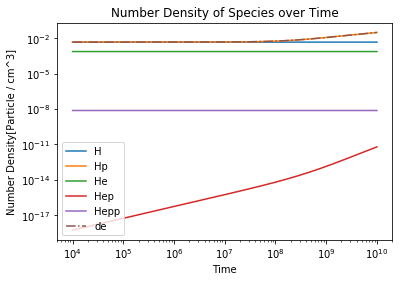

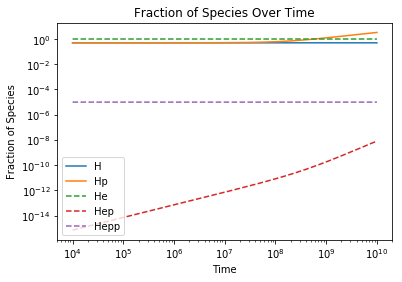

In [83]:
evolve(element_case=2, f_H = 0.5, f_He = 0.0, safety_factor=1000000, T0 = 10**4)

The only thing I could not figure out was what was going on with my dt. The professor said we were supposed to update dt every time step using the equation dt = safety_factor * min(S/Sdot) where S is the number density of the species and Sdot is the time derivative of the species. However, when I was implementing this earlier it would go to zero as time went on so the integration would never complete. I believe this is the opposite of what should be happeneing. This problem has gotten worse now that I have fixed all of my unit mistakes. Now when I try to implement the formula for dt my kernel crashes immediately. This makes me think I either did something wrong with my units or with my implementation of the dt formula.

I will use the method we used in class for dt instead, but keep my code for the new way of calculating dt commented

# Write-Up Question Answers:

### When is it slower and faster? When it is near equilibrium or far?

The code ran slower when adding more species into the mix. It also tended to go a little slower the larger I mad the initial temperature, but overall there wasn't much decrease. I would think the integration would take a shorter amount of time when things are changing within the system, but I did not test this too much. It seems to be in equilibrium for the start of most of the test cases I ran and then the system usually began to change around 10^8 sec and then it would reach another equilibrium after that. That mainly happened for the cases where f_H = 1.0. In the cases where f_H = 0.0 and f_H = 1e-6 most of the species stayed constant over time, but those that did change tended to chage up until 10^8 sec and then they would reach equilibrium.

It seems like 10^8 sec seems to be the magic number where things change. This was all tested for temperatures around 10^5.5 K, so temperature may play some effect on this as well. It does seem that it only reaches an equilibrium when the temperature is high enough.

### Do you see any particularly interesting regions in phase space?

Most of the interesting regions I discussed in the previous cell. The interesting regions mainly only appeared when the temperature was set to a high enough value(above 10^5 K). These regions mainly consisted of H or Hp changing around 10^8 sec while Hep would be changing during the entire simulation. 

It was interesting that de follows H or Hp so closely. I think this mainly was because of the change Dr. Turk made to how we handle the dnedt. I am not sure if I implemented it correctly 

# Issues I ran into:

So I ran into many issues throughout this assignemnt and I talked about many of them throughout this writeup, but I would like to make note of a few that have remained unsolved

* My fractions of the species over time plots will go above 1 at some times. I am not sure why this would happen since I don't think any H should become He or vice versa. I thought the only things that would change would be the ionization. I have triple checked my code and can't find out why that is happening, so that's a bummer.

* My plots don't look like how I think they should. When I was using the specific number densities as inputs I was getting much nicer looking plots. Meaning they have more curves and the ionizations would change for each species with respect to the other ones how I think they should. Now that I have implemented the ionization fractions as inputs my plots look pretty strange. I am not sure what happened there, but I think it may be due to an order of magnitude difference in what I was inputting and what was being calculated. This problem could stem from a misunderstanding of the units.

* Also, I getting that my de is following my H or Hp almost exactly which doesn't make much sense to me. I'm pretty sure that is wrong, but I have no idea why that is happening or how to fix it.

# Ending Comments

Hopefully I covered everything in this assignement! I don't think it is working perfectly, but I have coded up everything as I understand it, and debugged what I could. Thank you for a great semester. This has really been one of my favorite courses throughout my undergraduate career. I wish you the best of luck in the future iterations of this course!